# Table of contents
1. [Proteome data quality](#qc)
2. [WT v. fkh mutants scaling slopes](#wt_mut)
3. [Correlate FKH PWM score with scaling changes](#pwm)
4. [Correlate promoters that change scaling slope with PWM score against all other known budding yeast TFs](#other_tfs)
5. [Zoom in on known Fkh1/2 targets and their scaling](#known_targets)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import path
from re import findall
from glob import glob
from scipy import stats

from pyfaidx import Fasta

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Fkh delete scaling/'

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


def nonan_pairs(x,y):
    I = ~np.isnan(x)
    I = I & ~(np.isnan(y))
    return x[I],y[I]
def plot_bin_means(X,Y,bin_edges=None,mean='median',error='sem',color=None,
                   style='errorbar',minimum_n=25,bin_style='equal'):
    """
    Plot the mean/std values of Y given bin_edges in X
    
    INPUT:
        X, Y - the X and Y of the datat to bin over
        bin_edges - edges of binning
        mean - 'mean' or 'median'
        error - 'sem' (default) for standard error of mean or 'std' for standard deviation
        color - color to pass to errorbar
        minimum_n - minimum # of points per bin (default = 25)
        bin_style - 'equal' for equal spacing; 'percentile' for cohort
    
    RETURN:
        mean,std
    """
    
    assert(X.shape == Y.shape)
    
    X,Y = nonan_pairs(X,Y)
    
    # Flatten if not vectors
    if X.ndim > 1:
        X = X.flatten()
        Y = Y.flatten()
    
    if type(bin_edges) == int:
        if bin_style == 'equal':
            X_min = X.min()
            X_max = X.max() 
            bin_edges = np.linspace(X_min,X_max,num=bin_edges)
        elif bin_style == 'percentile':
            bin_edges = np.percentile(nonans(X),np.linspace(0,100,num=bin_edges))
            print(bin_edges)
    else:
        raise ValueError
    print(X)
    which_bin = np.digitize(X,bin_edges)
    Nbins = len(bin_edges)-1
    means = np.zeros(Nbins)
    stds = np.zeros(Nbins)

    # bin_centers = np.zeros(Nbins)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    for b in range(Nbins):
        y = Y[which_bin == b+1]
        # bin_centers[b] = (bin_edges[b] + bin_edges[b+1]) / 2
        # Suppress noisy bins
        if len(y) < minimum_n:
            means[b] = np.nan
            stds[b] = np.nan
        else:
            # Mean or median
            if mean == 'mean':
                means[b] = np.nanmean(y)
            elif mean == 'median':
                print(f'{y.shape}')
                means[b] = np.nanmedian(y)
    
            if error == 'sem':
                stds[b] = np.nanstd(y) / np.sqrt(len(y))
            elif error == 'std':
                stds[b] = y.std()

    # Plot
    if style == 'errorbar':
        plt.errorbar(bin_centers,means,stds,color=color)
    elif style == 'fill':
        plt.plot(bin_centers, means, color=color)
        plt.fill_between(bin_centers, means-stds, means+stds,
                         color=color,alpha=0.5)
        
    return means


## Quality control of proteome datasets <a name="qc"></a>

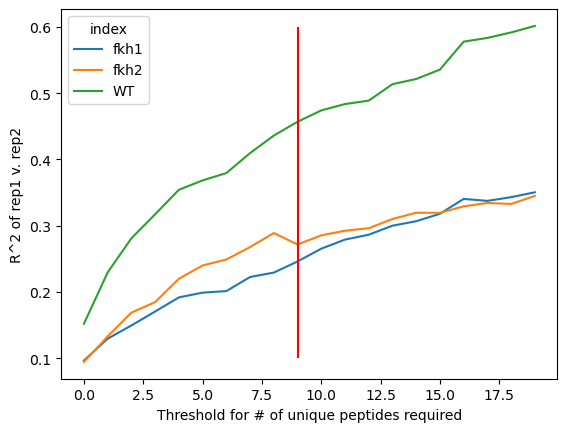

In [2]:
filename = '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/Fkh_Mass_Spec_edited.csv'
df = pd.read_csv(filename)
df.columns
df = df.rename(columns={'Gene names  (ordered locus )':'gene_name'})
df['gene_name'] = df['gene_name'].astype(str)
df = df.drop_duplicates(subset='gene_name')
df = df.set_index('gene_name')
df = df.drop('nan')

# Set peptide threshold
thresholds = np.arange(20)
R = pd.DataFrame(columns=thresholds)
for th in thresholds:
    _df = df[df['UniqID'] > th]
    R.loc['fkh1',th] = np.corrcoef(_df['fkh1_Slope_Expt1'],_df['fkh1_Slope_Expt2'])[0][1]**2
    R.loc['fkh2',th] = np.corrcoef(_df['fkh2_Slope_Expt1'],_df['fkh2_Slope_Expt2'])[0][1]**2
    R.loc['WT',th] = np.corrcoef(_df['WT_Slope_Expt1'],_df['WT_Slope_Expt2'])[0][1]**2

sb.lineplot(R.reset_index().melt('index'),hue='index',x='variable',y='value')
plt.xlabel('Threshold for # of unique peptides required')
plt.ylabel('R^2 of rep1 v. rep2')
plt.vlines(9, ymin=0.1,ymax=.6,color='r')

# Filter
df = df[df['UniqID'] > 9]
plt.savefig(path.join(dirname,'peptide_threshold.svg'),format='svg')

In [5]:
df

,Uniprot_name,UniqID,Conc_WT_00aTc_Expt1,Conc_WT_30aTc_Expt1,Conc_fkh1_00aTc_Expt1,Conc_fkh1_30aTc_Expt1,Conc_fkh2_00aTc_Expt1,Conc_fkh2_30aTc_Expt1,Conc_WT_00aTc_Expt2,Conc_WT_30aTc_Expt2,...,Gene names,Gene name,Keywords,Gene ontology (biological process),Gene ontology (cellular component),Gene ontology (GO),Gene ontology (molecular function),Gene ontology IDs,Subcellular location [CC],Function [CC]
gene_name,,,,,,,,,,,,,,,,,,,,,
YOR014W,2A5D_YEAST,32,0.972913,0.938524,1.027279,0.953159,1.042964,1.007423,1.018942,0.979955,...,RTS1 SCS1 YOR014W OR26.04,RTS1,Cytoplasm;Nucleus;Phosphoprotein;Reference pro...,cellular bud neck septin ring organization [GO...,cellular bud neck [GO:0005935]; condensed chro...,cellular bud neck [GO:0005935]; condensed chro...,DNA binding [GO:0003677]; protein phosphatase ...,GO:0000159; GO:0000776; GO:0000779; GO:0003677...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,FUNCTION: The B regulatory subunit might modul...
YAL016W,2AAA_YEAST,79,0.956391,0.906318,1.088462,0.878697,1.157068,1.013042,1.002349,0.929625,...,TPD3 YAL016W FUN32,TPD3,Reference proteome;Repeat,mitotic spindle assembly checkpoint [GO:000709...,cellular bud neck [GO:0005935]; cellular bud t...,cellular bud neck [GO:0005935]; cellular bud t...,protein phosphatase regulator activity [GO:001...,GO:0000159; GO:0005634; GO:0005737; GO:0005816...,NaN,FUNCTION: Phosphatase 2A affects a variety of ...
YGL190C,2ABA_YEAST,31,1.093772,0.992123,1.008112,1.010522,0.937407,1.000488,1.014605,0.986447,...,CDC55 YGL190C G1345,CDC55,Cell cycle;Phosphoprotein;Reference proteome;R...,homologous chromosome segregation [GO:0045143]...,cellular bud neck [GO:0005935]; cellular bud t...,cellular bud neck [GO:0005935]; cellular bud t...,protein phosphatase regulator activity [GO:001...,GO:0000159; GO:0000329; GO:0001100; GO:0005634...,NaN,FUNCTION: Phosphatase 2A affects a variety of ...
YJR149W,2NDP_YEAST,22,1.031767,1.084728,1.002165,1.044013,0.871665,0.909455,1.030702,0.938977,...,YJR149W J2213,NaN,Cytoplasm;FMN;Flavoprotein;Monooxygenase;Oxido...,NaN,cytoplasm [GO:0005737],cytoplasm [GO:0005737]; nitronate monooxygenas...,nitronate monooxygenase activity [GO:0018580],GO:0005737; GO:0018580,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000269|P...,FUNCTION: Catalyzes the oxidation of alkyl nit...
YJR025C,3HAO_YEAST,55,0.981921,0.968348,1.082143,0.951953,1.087721,0.892575,0.976756,1.027500,...,BNA1 HAD1 YJR025C J1550,BNA1,3D-structure;Cytoplasm;Dioxygenase;Iron;Metal-...,'de novo' NAD biosynthetic process from trypto...,cytoplasm [GO:0005737]; nucleus [GO:0005634],cytoplasm [GO:0005737]; nucleus [GO:0005634]; ...,"3-hydroxyanthranilate 3,4-dioxygenase activity...",GO:0000334; GO:0005634; GO:0005737; GO:0006569...,SUBCELLULAR LOCATION: Cytoplasm {ECO:0000255|H...,FUNCTION: Catalyzes the oxidative ring opening...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YOR087W,YVC1_YEAST,13,0.970755,0.863439,1.162043,0.865360,1.084033,0.876366,1.200068,0.894148,...,YVC1 YOR087W YOR088W YOR3151W,YVC1,Calcium;Calcium channel;Calcium transport;Ion ...,calcium ion import across plasma membrane [GO:...,fungal-type vacuole [GO:0000324]; fungal-type ...,fungal-type vacuole [GO:0000324]; fungal-type ...,calcium activated cation channel activity [GO:...,GO:0000324; GO:0000329; GO:0005216; GO:0005227...,SUBCELLULAR LOCATION: Vacuole membrane {ECO:00...,FUNCTION: Required for release of calcium ions...
YOL109W,ZEO1_YEAST,52,1.207202,0.863619,0.959297,0.818964,1.140652,1.005996,1.188543,0.927857,...,ZEO1 YOL109W O0738,ZEO1,Acetylation;Cell membrane;Coiled coil;Direct p...,fungal-type cell wall organization [GO:0031505],extrinsic component of plasma membrane [GO:001...,extrinsic component of plasma membrane [GO:001...,NaN,GO:0005739; GO:0005741; GO:0005886; GO:0019897...,SUBCELLULAR LOCATION: Cell membrane {ECO:00002...,FUNCTION: Acts antagonistically to MID2 in sig...
YGR211W,ZPR1_YEAST,113,0.912929,0.974986,1.039101,0.958823,1.057088,1.0347

In [3]:
df.loc['YML085C']

Uniprot_name                                                                 TBA1_YEAST
UniqID                                                                              106
Conc_WT_00aTc_Expt1                                                            0.916054
Conc_WT_30aTc_Expt1                                                            0.799442
Conc_fkh1_00aTc_Expt1                                                          1.106101
                                                            ...                        
Gene ontology (GO)                    cytoplasm [GO:0005737]; cytoplasmic microtubul...
Gene ontology (molecular function)    GTPase activity [GO:0003924]; GTP binding [GO:...
Gene ontology IDs                     GO:0000070; GO:0000226; GO:0000278; GO:0000280...
Subcellular location [CC]                SUBCELLULAR LOCATION: Cytoplasm, cytoskeleton.
Function [CC]                         FUNCTION: Tubulin is the major constituent of ...
Name: YML085C, Length: 139, dtyp

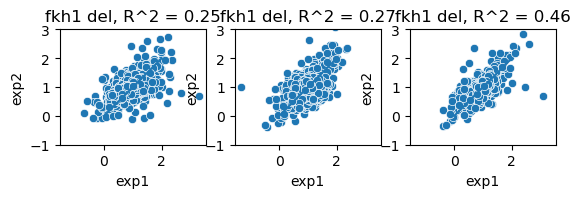

In [4]:
'''
Supplemental Figure XX
Replicate v. replicates
'''

wt_slopes = df[['WT_Slope_Expt1','WT_Slope_Expt2']]
wt_slopes = wt_slopes.rename(columns={'WT_Slope_Expt1':'exp1','WT_Slope_Expt2':'exp2'})
fkh1_slopes = df[['fkh1_Slope_Expt1','fkh1_Slope_Expt2']]
fkh1_slopes = fkh1_slopes.rename(columns={'fkh1_Slope_Expt1':'exp1','fkh1_Slope_Expt2':'exp2'})
fkh2_slopes = df[['fkh2_Slope_Expt1','fkh2_Slope_Expt2']]
fkh2_slopes = fkh2_slopes.rename(columns={'fkh2_Slope_Expt1':'exp1','fkh2_Slope_Expt2':'exp2'})

# sb.scatterplot(wt_slopes,x='exp1',y='exp2')
ax1 = plt.subplot(131)
sb.scatterplot(fkh1_slopes,x='exp1',y='exp2')
plt.plot([0,2],[0,2]); plt.ylim([-1,3])
ax1.set_aspect('equal', adjustable='box')
R,P = np.corrcoef(fkh1_slopes['exp1'],fkh1_slopes['exp2'])
plt.title(f'fkh1 del, R^2 = {R[1]**2:.2f}')

ax2 = plt.subplot(132, sharex=ax1)
sb.scatterplot(fkh2_slopes,x='exp1',y='exp2')
plt.plot([0,2],[0,2]); plt.ylim([-1,3])
ax2.set_aspect('equal', adjustable='box')
plt.title('Scaling slopes in fkh2 del')
R,P = np.corrcoef(fkh2_slopes['exp1'],fkh2_slopes['exp2'])
plt.title(f'fkh1 del, R^2 = {R[1]**2:.2f}')

ax2 = plt.subplot(133, sharex=ax1)
sb.scatterplot(wt_slopes,x='exp1',y='exp2')
plt.plot([0,2],[0,2]); plt.ylim([-1,3])
ax2.set_aspect('equal', adjustable='box')
plt.title('Scaling slopes in WT')
R,P = np.corrcoef(wt_slopes['exp1'],wt_slopes['exp2'])
plt.title(f'fkh1 del, R^2 = {R[1]**2:.2f}')

plt.savefig(path.join(dirname,'replicates.eps'),format='eps')

In [5]:
print(wt_slopes.loc['YML085C'])
print(fkh1_slopes.loc['YML085C'])
print(fkh2_slopes.loc['YML085C'])

exp1    0.665960
exp2    0.728145
Name: YML085C, dtype: float64
exp1    0.438624
exp2    0.633730
Name: YML085C, dtype: float64
exp1    0.739590
exp2    0.763657
Name: YML085C, dtype: float64


## WT v. mutant scaling slopes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


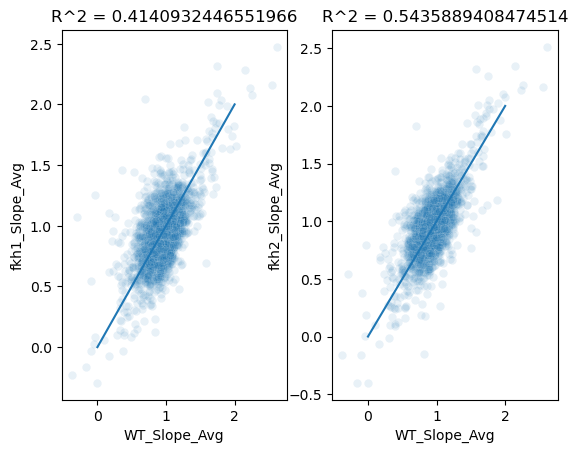

In [6]:
'''
(Fig 6)
'''

plt.subplot(1,2,1)
sb.scatterplot(df,x='WT_Slope_Avg',y='fkh1_Slope_Avg',alpha=0.1)
plt.plot([0,2],[0,2])
# plt.plot([0,2],[0.5,2.5])
# plt.plot([0,2],[-0.5,1.5])
# df[df['fkh2_Slope_Avg']  & df['fkh1_Slope_Avg']
R,P = np.corrcoef(df['WT_Slope_Avg'],df['fkh1_Slope_Avg'])
plt.title(f'R^2 = {R[1]**2}')

plt.subplot(1,2,2)
sb.scatterplot(df,x='WT_Slope_Avg',y='fkh2_Slope_Avg',alpha=0.1)
plt.plot([0,2],[0,2])
# plt.plot([0,2],[0.5,2.5])
# plt.plot([0,2],[-0.5,1.5])
# df[df['fkh2_Slope_Avg']  & df['fkh1_Slope_Avg']
R,P = np.corrcoef(df['WT_Slope_Avg'],df['fkh2_Slope_Avg'])
plt.title(f'R^2 = {R[1]**2}')
plt.savefig(path.join(dirname,'WT_slope_v_fkh_slope.eps'),format='eps')



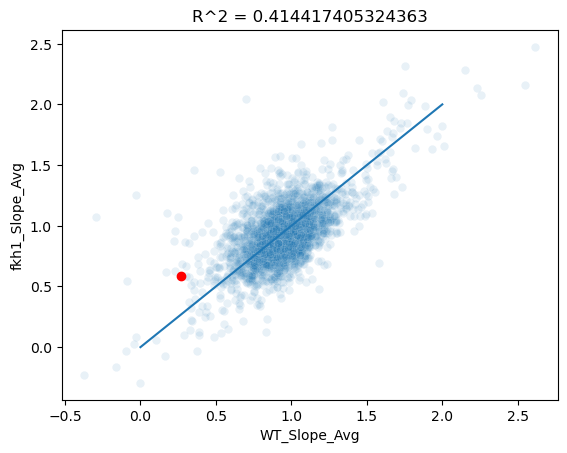

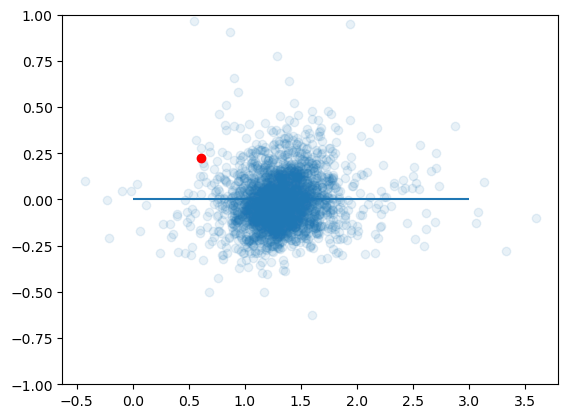

In [8]:

df.loc['WHI5 - qPCR','Gene Name'] = 'WHI5 - qPCR'
df.loc['WHI5 - qPCR','WT_Slope_Avg'] = 0.269
df.loc['WHI5 - qPCR','fkh1_Slope_Avg'] = 0.587
df.loc['WHI5 - qPCR','fkh2_Slope_Avg'] = 0.746

delta_slopes = pd.DataFrame()
delta_slopes['Name'] = df['Gene name']
delta_slopes['WT'] = df['WT_Slope_Avg']
delta_slopes['fkh1'] = df['fkh1_Slope_Avg']
delta_slopes['fkh2'] = df['fkh2_Slope_Avg']
delta_slopes['fkh1_del'] = df['fkh1_Slope_Avg'] - df['WT_Slope_Avg']
delta_slopes['fkh2_del'] = df['fkh2_Slope_Avg'] - df['WT_Slope_Avg']

# plt.subplot(1,2,1)
sb.scatterplot(df,x='WT_Slope_Avg',y='fkh1_Slope_Avg',alpha=0.1)
plt.scatter(df.loc['WHI5 - qPCR']['WT_Slope_Avg'],df.loc['WHI5 - qPCR']['fkh1_Slope_Avg'],alpha=1,color='r')
plt.plot([0,2],[0,2])
# df[df['fkh2_Slope_Avg']  & df['fkh1_Slope_Avg']
R,P = np.corrcoef(df['WT_Slope_Avg'],df['fkh1_Slope_Avg'])
plt.title(f'R^2 = {R[1]**2}')

# plt.subplot(1,2,2)
# sb.scatterplot(delta_slopes,x='WT',y='fkh1_del',alpha=0.1)
# plt.hlines(0.2,xmin=0,xmax=2)

# Transform data by rotating 45 degrees
R = np.matrix([[np.cos(np.pi/4),np.sin(np.pi/4)],[-np.sin(np.pi/4),np.cos(np.pi/4)]])
from numpy import linalg
x = df[['WT_Slope_Avg','fkh1_Slope_Avg']].values
x_rot = np.zeros_like(x)
for i,row in enumerate(x):
    x_rot[i,:] = linalg.matmul(R,row)
    
# plt.subplot(1,2,2)
plt.figure()
plt.scatter(x_rot[:,0],x_rot[:,1],alpha=0.1)
plt.scatter(x_rot[-1,0],x_rot[-1,1],alpha=1,color='r')
plt.ylim([-1,1])
plt.hlines(0,xmin=0,xmax=3)
delta_slopes['fkh1_deviation_from_wt'] = x_rot[:,1]
delta_slopes['fkh1_covary_with_wt'] = x_rot[:,0]

# Transform data by rotating 45 degrees
x = df[['WT_Slope_Avg','fkh2_Slope_Avg']].values
x_rot = np.zeros_like(x)
for i,row in enumerate(x):
    x_rot[i,:] = linalg.matmul(R,row)
delta_slopes['fkh2_deviation_from_wt'] = x_rot[:,1]
delta_slopes['fkh2_covary_with_wt'] = x_rot[:,0]

delta_slopes.to_csv(path.join(dirname,'delta_slopes.csv'))

gene_name
YOR014W        0.040256
YAL016W       -0.258504
YGL190C       -0.037552
YJR149W        0.001369
YJR025C        0.045941
                 ...   
YOL109W       -0.640956
YGR211W        0.125465
YMR243C       -0.232342
YGR285C        0.128823
WHI5 - qPCR   -0.715970
Name: fkh1_covary_with_wt, Length: 2530, dtype: float64
(38,)
(218,)
(935,)
(967,)
(273,)
(41,)
gene_name
YOR014W        0.004395
YAL016W       -0.164507
YGL190C        0.006325
YJR149W       -0.088677
YJR025C       -0.094117
                 ...   
YOL109W       -0.800825
YGR211W        0.222518
YMR243C       -0.065007
YGR285C        0.160511
WHI5 - qPCR   -0.623080
Name: fkh2_covary_with_wt, Length: 2530, dtype: float64
(45,)
(225,)
(932,)
(983,)
(236,)
(44,)


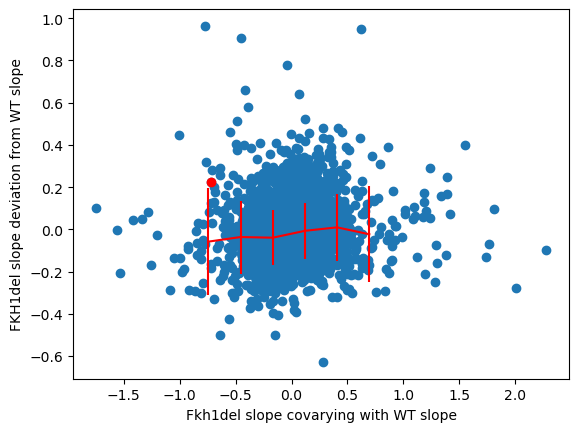

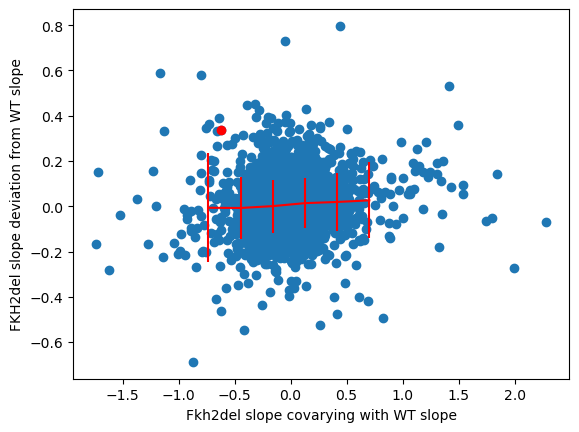

In [31]:
plt.figure()
plt.scatter(delta_slopes['fkh1_covary_with_wt'] - delta_slopes['fkh1_covary_with_wt'].mean(),delta_slopes['fkh1_deviation_from_wt'])
plt.scatter(delta_slopes.loc['WHI5 - qPCR','fkh1_covary_with_wt'] - delta_slopes['fkh1_covary_with_wt'].mean(),
            delta_slopes.loc['WHI5 - qPCR','fkh1_deviation_from_wt'],alpha=1,color='r')

plot_bin_means(delta_slopes['fkh1_covary_with_wt'] - delta_slopes['fkh1_covary_with_wt'].mean(),
               delta_slopes['fkh1_deviation_from_wt'],bin_edges = 15,color='r',error='std')
plt.xlabel('Fkh1del slope covarying with WT slope')
plt.ylabel('FKH1del slope deviation from WT slope')
plt.savefig(path.join(dirname,'covarying_v_deviance_fkh1.eps'),format='eps')

plt.figure()
plt.scatter(delta_slopes['fkh2_covary_with_wt'] - delta_slopes['fkh2_covary_with_wt'].mean(),delta_slopes['fkh2_deviation_from_wt'])
plt.scatter(delta_slopes.loc['WHI5 - qPCR','fkh2_covary_with_wt'] - delta_slopes['fkh2_covary_with_wt'].mean(),
            delta_slopes.loc['WHI5 - qPCR','fkh2_deviation_from_wt'],alpha=1,color='r')

plot_bin_means(delta_slopes['fkh2_covary_with_wt'] - delta_slopes['fkh2_covary_with_wt'].mean(),
               delta_slopes['fkh2_deviation_from_wt'],bin_edges = 15,color='r',error='std')
plt.xlabel('Fkh2del slope covarying with WT slope')
plt.ylabel('FKH2del slope deviation from WT slope')

plt.savefig(path.join(dirname,'covarying_v_deviance_fkh2.eps'),format='eps')

## Subset promoters that change their scaling

In [33]:
# Grab promoter sequences

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Whi5/'

#23288841 is Sc assemblyID
yeast_genome = glob(path.join(dirname,f'Genomes/23288841/GCF_000146045.2_R64_genomic.fa'))
yeast_genome = Fasta(yeast_genome[0])

# All promoters from SCG
promoters = glob(path.join(dirname,f'all_S228C_ORFs/orf_genomic_1000_all.fasta'))
promoters = Fasta(promoters[0])
                     
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T

def get_pswm_score(mat,seq):
    L = len(mat)
    N = len(seq)
    return np.array([ np.sum([mat.loc[k,v] for k,v in enumerate( list(seq[i:i+L]) )]) for i in range(N-L) ])

def get_pswm_score_fast(mat: pd.DataFrame, seq: str):
    L = len(mat)
    N = len(seq)
    A = mat.columns

    # Create a lookup table: character to column index
    col_lookup = {c: i for i, c in enumerate(A)}

    # Convert sequence to numeric indices
    seq_idx = np.array([col_lookup[c] for c in seq])

    # Extract sliding windows (N-L+1, L)
    windows = np.lib.stride_tricks.sliding_window_view(seq_idx, window_shape=L)

    # Now we need to look up mat.loc[k, v] for each position k and base v
    # windows.shape = (N-L+1, L)
    # So we construct two arrays:
    #   rows = [0, 1, 2, ..., L-1]
    #   cols = windows[i, :]
    row_idx = np.arange(L)  # Shape (L,)
    scores = np.array([mat.values[row_idx, win] for win in windows])

    return scores.sum(axis=1)

def extract_promoters_by_gene_name(promoters,genes):
    return [SeqRecord( Seq(promoters[name][500:1000].seq), id=name) 
                          for name in genes if name in promoters.keys()]


def plot_slopegraph(X,Y,color='b',names=None):
    """
    Implements a Tufte's slopegraph for two paired lists
    
    Inputs:
        X,Y paired
        color - optional, default 'b'
        names - [X_name,Y_name] (optional)
    """
    
    assert(len(X) == len(Y)), 'X and Y must have same length'
    assert( (np.ndim(X) == np.ndim(Y)) & np.ndim(X) == 1 ), 'X and Y must be 1-dimensional arrays'
    
    N = len(X)
    for i in range(N):
        # Skip if one of value is NaN
        x = X[i]; y = Y[i]
        if ~np.isnan(x) and ~np.isnan(y):
            # Plot X, Y as scatter first
            plt.scatter([1,2],[x,y],color=color)
            # Plot slope
            plt.plot([1,2],[x,y],color=color)
            if names is not None:
                plt.xticks([1,2],names)

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Fkh delete scaling/'


In [34]:
fkh1_delta_cutoff = delta_slopes['fkh1_deviation_from_wt'].mean() + 2*delta_slopes['fkh1_deviation_from_wt'].std()
fkh2_delta_cutoff = delta_slopes['fkh2_deviation_from_wt'].mean() + 2*delta_slopes['fkh2_deviation_from_wt'].std()

fkh1_delta_cutoff_original_coords = fkh1_delta_cutoff*np.sqrt(2)
fkh2_delta_cutoff_original_coords = fkh2_delta_cutoff*np.sqrt(2)

print(f'fkh1 delta cutoff: {fkh1_delta_cutoff}')
print(f'fkh2 delta cutoff: {fkh2_delta_cutoff}')

fkh1_lower = delta_slopes[delta_slopes['fkh1_deviation_from_wt'] < -fkh1_delta_cutoff]
print(f'fkh1del | lower | {len(fkh1_lower)}')
fkh1_higher = delta_slopes[delta_slopes['fkh1_deviation_from_wt'] > fkh1_delta_cutoff]
print(f'fkh1del | higher | {len(fkh1_higher)}')

fkh2_lower = delta_slopes[delta_slopes['fkh2_deviation_from_wt'] < -fkh2_delta_cutoff]
print(f'fkh2del | lower | {len(fkh2_lower)}')
fkh2_higher = delta_slopes[delta_slopes['fkh2_deviation_from_wt'] > fkh2_delta_cutoff]
print(f'fkh2del | higher | {len(fkh2_higher)}')


fkh1 delta cutoff: 0.28095876401580777
fkh2 delta cutoff: 0.25756735424090044
fkh1del | lower | 44
fkh1del | higher | 83
fkh2del | lower | 36
fkh2del | higher | 70


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


44

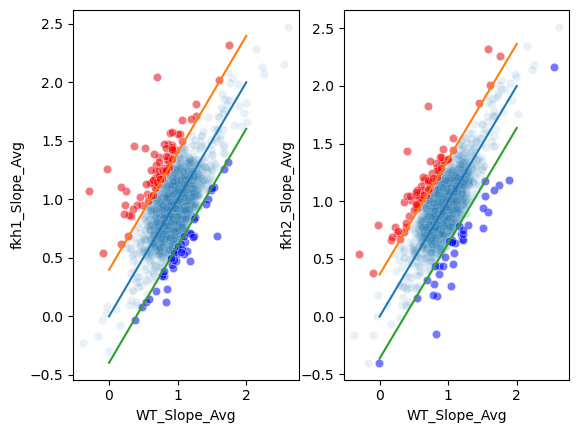

In [35]:
'''
Figure 6B,C
'''
plt.subplot(1,2,1)
sb.scatterplot(df,x='WT_Slope_Avg',y='fkh1_Slope_Avg',alpha=0.1)
plt.plot([0,2],[0,2])
plt.plot([0,2],[fkh1_delta_cutoff_original_coords,2+fkh1_delta_cutoff_original_coords])
plt.plot([0,2],[-fkh1_delta_cutoff_original_coords,2-fkh1_delta_cutoff_original_coords])
sb.scatterplot(df[ df['fkh1_Slope_Avg'] > df['WT_Slope_Avg'] + fkh1_delta_cutoff_original_coords],
               x='WT_Slope_Avg',y='fkh1_Slope_Avg',color='r',alpha=0.5)
sb.scatterplot(df[ df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords],
               x='WT_Slope_Avg',y='fkh1_Slope_Avg',color='b',alpha=0.5)

# df[df['fkh2_Slope_Avg']  & df['fkh1_Slope_Avg']
R,P = np.corrcoef(df['WT_Slope_Avg'],df['fkh1_Slope_Avg'])


plt.subplot(1,2,2)
sb.scatterplot(df,x='WT_Slope_Avg',y='fkh2_Slope_Avg',alpha=0.1)
plt.plot([0,2],[0,2])
plt.plot([0,2],[fkh2_delta_cutoff_original_coords,2+fkh2_delta_cutoff_original_coords])
plt.plot([0,2],[-fkh2_delta_cutoff_original_coords,2-fkh2_delta_cutoff_original_coords])
sb.scatterplot(df[ df['fkh2_Slope_Avg'] > df['WT_Slope_Avg'] + fkh2_delta_cutoff_original_coords],
               x='WT_Slope_Avg',y='fkh2_Slope_Avg',color='r',alpha=0.5)
sb.scatterplot(df[ df['fkh2_Slope_Avg'] < df['WT_Slope_Avg'] - fkh2_delta_cutoff_original_coords],
               x='WT_Slope_Avg',y='fkh2_Slope_Avg',color='b',alpha=0.5)
# df[df['fkh2_Slope_Avg']  & df['fkh1_Slope_Avg']
R,P = np.corrcoef(df['WT_Slope_Avg'],df['fkh2_Slope_Avg'])

plt.savefig(path.join(dirname,'filter_criterion.eps'),format='eps')
len(df[ df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


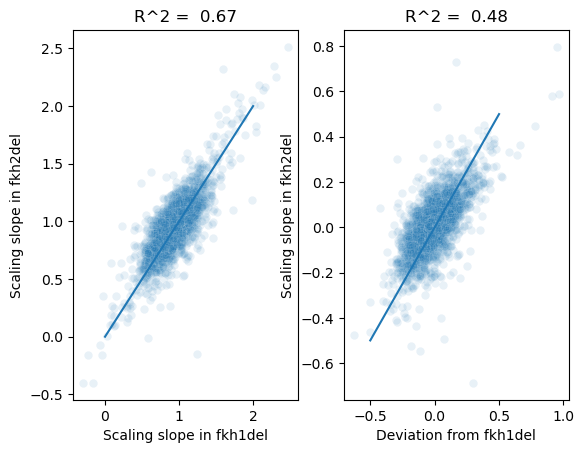

In [36]:
'''
Figure 6D
'''

plt.subplot(1,2,1)
sb.scatterplot(df,x='fkh1_Slope_Avg',y='fkh2_Slope_Avg',alpha=0.1)
plt.plot([0,2],[0,2])
plt.xlabel('Scaling slope in fkh1del')
plt.ylabel('Scaling slope in fkh2del')
R,P = np.corrcoef(df['fkh1_Slope_Avg'], df['fkh2_Slope_Avg'])
plt.title(f'R^2 = {R[1]**2 : .2f}')

plt.subplot(1,2,2)
sb.scatterplot(delta_slopes,x='fkh1_deviation_from_wt',y='fkh2_deviation_from_wt',alpha=0.1)
plt.plot([-.5,.5],[-0.5,.5])
plt.xlabel('Deviation from fkh1del')
plt.ylabel('Scaling slope in fkh2del')
R,P = np.corrcoef(delta_slopes['fkh1_deviation_from_wt'], delta_slopes['fkh2_deviation_from_wt'])
plt.title(f'R^2 = {R[1]**2 : .2f}')

plt.savefig(path.join(dirname,'fkh1_fkh2_deviations.eps'),format='eps')


### Export filtered subset to .fasta files

In [37]:
# Dict of {filename : promoter sequences}

promoter_sets = {'all_promoters':list(promoters.keys()),
                 'all_proteome':[name for name,_ in delta_slopes.iterrows()],
                 'Fkh1_nochange':[name for name,row in delta_slopes.iterrows() if np.abs(row['fkh1_del']) < 0.05],
                 # Fkh1
                 'higher_in_fkh1del_originally_subscaling':[ name for name in df[
                                                            (df['fkh1_Slope_Avg'] > df['WT_Slope_Avg'] + fkh1_delta_cutoff_original_coords)
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'lower_in_fkh1del_originally_subscaling':[ name for name in df[
                                                            (df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords)
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'higher_in_fkh1del':[ name for name in
                                       df[(df['fkh1_Slope_Avg'] > df['WT_Slope_Avg'] + fkh1_delta_cutoff_original_coords)].index],
                 'lower_in_fkh1del':[ name for name in
                                       df[(df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords)].index],
                  # Fkh2
                 'higher_in_fkh2del_originally_subscaling':[ name for name in df[
                                                            (df['fkh2_Slope_Avg'] > df['WT_Slope_Avg'] + fkh2_delta_cutoff_original_coords)
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'lower_in_fkh2del_originally_subscaling':[ name for name in df[
                                                            (df['fkh2_Slope_Avg'] < df['WT_Slope_Avg'] - fkh2_delta_cutoff_original_coords)
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'higher_in_fkh2del':[ name for name in
                                       df[(df['fkh2_Slope_Avg'] > df['WT_Slope_Avg'] + fkh2_delta_cutoff_original_coords)].index],
                 'lower_in_fkh2del':[ name for name in
                                       df[(df['fkh2_Slope_Avg'] < df['WT_Slope_Avg'] - fkh2_delta_cutoff_original_coords)].index],
                 # Either Fkh1 and Fkh2
                  'higher_in_fkh12del_originally_subscaling':[ name for name in df[
                                                            ((df['fkh1_Slope_Avg'] > df['WT_Slope_Avg'] + fkh1_delta_cutoff_original_coords)
                                                           | (df['fkh2_Slope_Avg'] > df['WT_Slope_Avg'] + fkh2_delta_cutoff_original_coords))
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'lower_in_fkh12del_originally_subscaling':[ name for name in df[
                                                            ((df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords)
                                                           | (df['fkh2_Slope_Avg'] < df['WT_Slope_Avg'] - fkh2_delta_cutoff_original_coords))
                                                           & (df['WT_Slope_Avg'] < 0.9)].index],
                 'higher_in_fkh12del':[ name for name in df[
                                                (df['fkh1_Slope_Avg'] > df['WT_Slope_Avg'] + fkh1_delta_cutoff_original_coords)
                                               | (df['fkh2_Slope_Avg'] > df['WT_Slope_Avg'] + fkh2_delta_cutoff_original_coords)].index],
                 'lower_in_fkh12del':[ name for name in df[
                                                (df['fkh1_Slope_Avg'] < df['WT_Slope_Avg'] - fkh1_delta_cutoff_original_coords)
                                               | (df['fkh2_Slope_Avg'] < df['WT_Slope_Avg'] - fkh2_delta_cutoff_original_coords)].index], 
                }


In [38]:
[(condition,len(g)) for condition,g in promoter_sets.items()]

[('all_promoters', 6722),
 ('all_proteome', 2530),
 ('Fkh1_nochange', 535),
 ('higher_in_fkh1del_originally_subscaling', 66),
 ('lower_in_fkh1del_originally_subscaling', 11),
 ('higher_in_fkh1del', 83),
 ('lower_in_fkh1del', 44),
 ('higher_in_fkh2del_originally_subscaling', 59),
 ('lower_in_fkh2del_originally_subscaling', 10),
 ('higher_in_fkh2del', 70),
 ('lower_in_fkh2del', 36),
 ('higher_in_fkh12del_originally_subscaling', 95),
 ('lower_in_fkh12del_originally_subscaling', 18),
 ('higher_in_fkh12del', 118),
 ('lower_in_fkh12del', 67)]

In [39]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Fkh delete scaling/'

# Use gene sets to extract promoter seqs + save
for condition,genes in promoter_sets.items():
    proms = extract_promoters_by_gene_name(promoters, genes)
    print(f'{condition} = {len(proms)}')
    SeqIO.write(proms,path.join(dirname,f'XSTREME/{condition}.fasta'),'fasta')

all_promoters = 6722


NameError: name 'SeqIO' is not defined

## Correlate FKH PWM score with scaling changes

In [40]:
'''
Correlate Fkh1 PSWM score with scaling changes
'''

# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
        delta_slopes.loc[gene,'Fkh1 score'] = get_pswm_score_fast(Fkh,seq).mean()

# Load PSWM for Fkh2
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
        delta_slopes.loc[gene,'Fkh2 score'] = get_pswm_score_fast(Fkh,seq).mean()


100%|█████████████████████████████████████| 2530/2530 [00:01<00:00, 1565.37it/s]


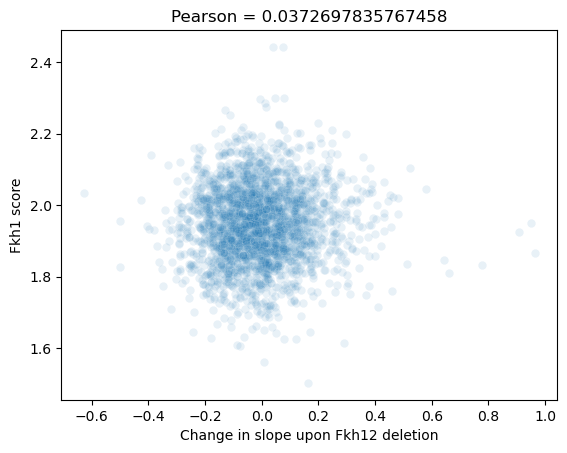

In [41]:
sb.scatterplot(delta_slopes,x='fkh1_deviation_from_wt',y='Fkh1 score',alpha=0.1)
_x = delta_slopes[delta_slopes['WT'] < .9].dropna()
R,P = np.corrcoef(_x['fkh1_deviation_from_wt'],_x['Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh12 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_1del_v_1score.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_1del_v_1score.svg', format='svg')

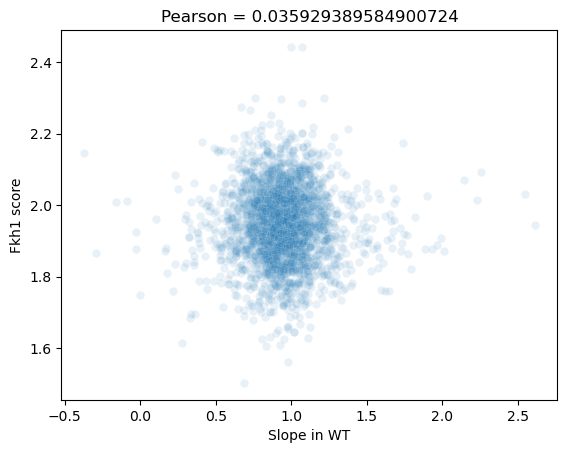

In [42]:
sb.scatterplot(delta_slopes,x='WT',y='Fkh1 score',alpha=0.1)
_x = delta_slopes[delta_slopes['WT'] < .9].dropna()
R,P = np.corrcoef(_x['WT'],_x['Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Slope in WT')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/wtslope_v_1score.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/wtslope_v_1score.svg', format='svg')

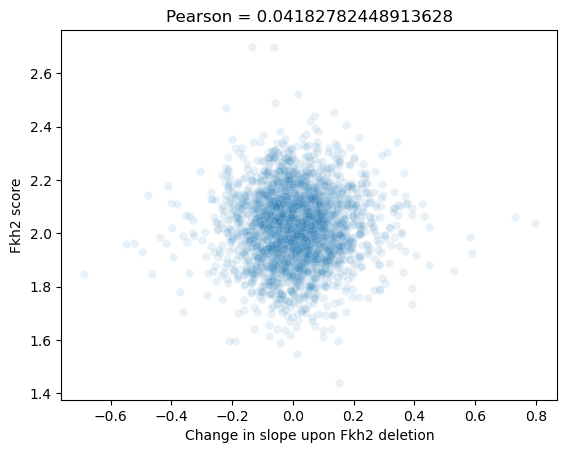

In [43]:
sb.scatterplot(delta_slopes,x='fkh2_deviation_from_wt',y='Fkh2 score',alpha=0.1)
_x = delta_slopes[delta_slopes['WT'] < .9].dropna()
R,P = np.corrcoef(_x['fkh2_deviation_from_wt'],_x['Fkh2 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh2 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_2score.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_2score.svg', format='svg')

In [44]:
'''

Truncate the motifs to ~AAACA

'''

# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,3,4,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

#print logo
#from Bio import motifs
Fkh # AACAA

for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
        delta_slopes.loc[gene,'Truncated Fkh1 score'] = get_pswm_score_fast(Fkh,seq).mean()

delta_slopes.to_csv(path.join(dirname,'delta_slopes.csv'))

100%|█████████████████████████████████████| 2530/2530 [00:01<00:00, 1512.60it/s]


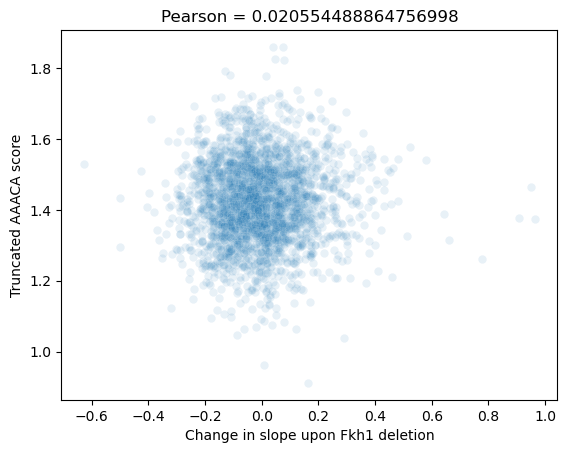

In [45]:
sb.scatterplot(delta_slopes,x='fkh1_deviation_from_wt',y='Truncated Fkh1 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh1_deviation_from_wt'],delta_slopes.dropna()['Truncated Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.ylabel('Truncated AAACA score')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_AAACAscore.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_AAACAscore.svg', format='svg')

In [46]:
delta_slopes.columns

Index(['Name', 'WT', 'fkh1', 'fkh2', 'fkh1_del', 'fkh2_del',
       'fkh1_deviation_from_wt', 'fkh1_covary_with_wt',
       'fkh2_deviation_from_wt', 'fkh2_covary_with_wt', 'Fkh1 score',
       'Fkh2 score', 'Truncated Fkh1 score'],
      dtype='object')

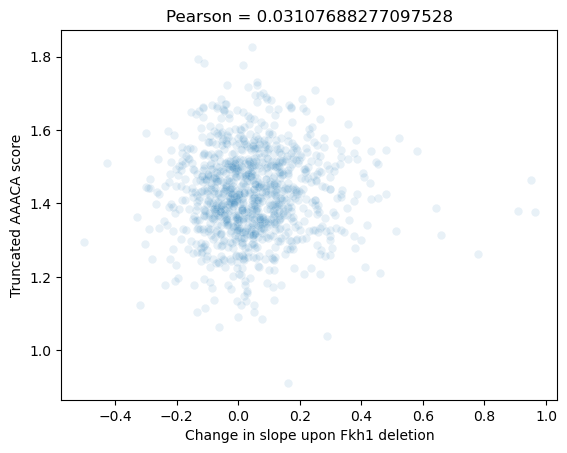

In [47]:
# Only look at WT subscaling genes

sb.scatterplot(delta_slopes[delta_slopes['WT'] < 0.9],x='fkh1_deviation_from_wt',y='Truncated Fkh1 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes[delta_slopes['WT'] < 0.9].dropna()['fkh1_deviation_from_wt'],delta_slopes[delta_slopes['WT'] < 0.9].dropna()['Truncated Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.ylabel('Truncated AAACA score')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_AAACAscore.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/delta_slope_2del_v_AAACAscore.svg', format='svg')

In [48]:
'''

Load all motifs

'''

from glob import glob
from os import path

filenames = glob('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/curated PWMs/ALIGNED_ENOLOGO_FORMAT_PWMS/*.pwm')
motifs = {}

for f in filenames:
    basename = path.splitext(path.split(f)[1])[0]
    tf_name,motif_name = basename.split('_')
    _df = pd.read_csv(f,sep='\t',index_col=0, header=None).T.reset_index(drop=True)
    motifs[(tf_name,motif_name)] = _df 


In [49]:
# Find tf that has maximum motifID (don't know how it's ordered)

motif_manifest = pd.DataFrame()
motif_manifest['Gene name'] = [g for g,m in motifs.keys()]
motif_manifest['MotifID'] = [m for g,m in motifs.keys()]

grouped = [m for gene_name, m in motif_manifest.groupby('Gene name')]

print(f'Total of {len(motif_manifest)} motifs for {len(motif_manifest['Gene name'].unique())} TFs')

Total of 244 motifs for 206 TFs


In [50]:
# Do run motif score and correlate with slope change

motif_correlations = pd.DataFrame(columns=['Fkh1del_correlation','Fkh2del_correlation'],
                                 index=motif_manifest['Gene name'])

motif_correlations.loc['Fkh1','Fkh1del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh1 score'],
                                                                   delta_slopes.dropna()['fkh1_deviation_from_wt'])[0][1]
motif_correlations.loc['Fkh1','Fkh2del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh1 score'],
                                                                   delta_slopes.dropna()['fkh2_deviation_from_wt'])[0][1]
motif_correlations.loc['Fkh2','Fkh1del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh2 score'],
                                                                   delta_slopes.dropna()['fkh1_deviation_from_wt'])[0][1]
motif_correlations.loc['Fkh2','Fkh2del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh2 score'],
                                                                   delta_slopes.dropna()['fkh2_deviation_from_wt'])[0][1]


## Correlate promoters that change scaling slope with PWM score against all other known budding yeast TFs

In [51]:

_x = delta_slopes[delta_slopes['WT'] < 0.9].dropna()
gene2test = [gene for gene in _x.index if gene in promoters.keys()]

for _,m in tqdm(motif_manifest.iterrows()):
    gene_name = m['Gene name']
    motifID = m['MotifID']
    motif = motifs[(gene_name,motifID)]

    scores = np.array([ get_pswm_score_fast(motif, promoters[gene][500:1000].seq).mean()
                      for gene in _x.dropna().index if gene in promoters.keys()])
    
    R,P = np.corrcoef(scores,_x.loc[gene2test,'fkh1_deviation_from_wt'].values)
    motif_correlations.loc[gene_name, 'Fkh1del_correlation'] = R[1]
    R,P = np.corrcoef(scores,_x.loc[gene2test,'fkh2_deviation_from_wt'].values)
    motif_correlations.loc[gene_name, 'Fkh2del_correlation'] = R[1]
    

9it [00:05,  1.56it/s]


KeyboardInterrupt: 

In [ ]:
motif_correlations = motif_correlations.drop_duplicates()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


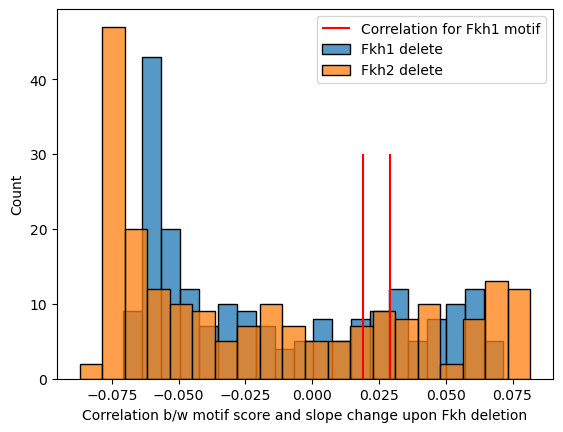

In [60]:
sb.histplot(motif_correlations,x='Fkh1del_correlation',bins=20)
sb.histplot(motif_correlations,x='Fkh2del_correlation',bins=20)
plt.xlabel('Correlation b/w motif score and slope change upon Fkh deletion')
plt.vlines(motif_correlations.loc['Fkh1'],ymin=0,ymax=30,color='r')
plt.legend(['Correlation for Fkh1 motif','Fkh1 delete','Fkh2 delete'])

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/all_PWM_correlation_with_fkhslopechange.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/all_PWM_correlation_with_fkhslopechange.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


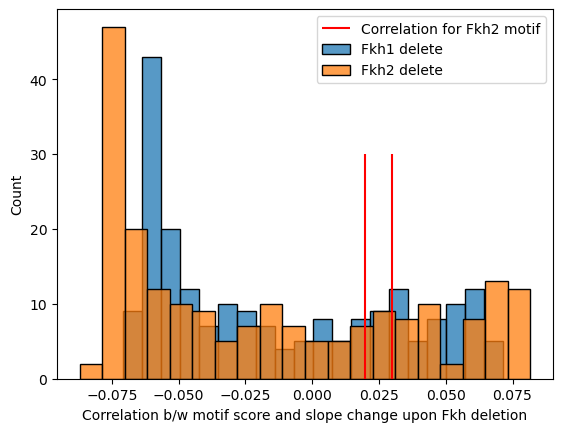

In [61]:
sb.histplot(motif_correlations,x='Fkh1del_correlation',bins=20)
sb.histplot(motif_correlations,x='Fkh2del_correlation',bins=20)
plt.xlabel('Correlation b/w motif score and slope change upon Fkh deletion')
plt.vlines(motif_correlations.loc['Fkh2'],ymin=0,ymax=30,color='r')
plt.legend(['Correlation for Fkh2 motif','Fkh1 delete','Fkh2 delete'])

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/all_PWM_correlation_with_fkhslopechange_fkh2highlighted.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling/all_PWM_correlation_with_fkhslopechange_fkh2highlighted.eps', format='eps')

<Axes: xlabel='Fkh1del_correlation', ylabel='Fkh2del_correlation'>

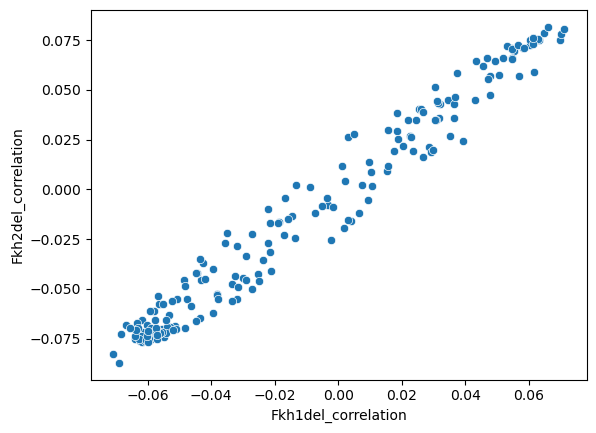

In [62]:

sb.scatterplot(motif_correlations,x='Fkh1del_correlation',y='Fkh2del_correlation')

In [63]:
print('---TF motifs presence that anti-correlate with slope change---')
print(motif_correlations.sort_values('Fkh1del_correlation').head(10))
print('---TF motifs presence that correlate with slope change---')
print(motif_correlations.sort_values('Fkh1del_correlation').tail(10))

---TF motifs presence that anti-correlate with slope change---
          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YOR140W             -0.070817           -0.082895
YER064C             -0.068926           -0.087085
YBR066C             -0.068538           -0.072478
YGL071W               -0.0669           -0.068233
YPL202C             -0.065701           -0.069811
YKL015W              -0.06404           -0.074934
YOR162C             -0.063991           -0.073427
YLR375W             -0.063816           -0.070778
YPR008W             -0.063745           -0.073312
YDL002C             -0.063303           -0.067266
---TF motifs presence that correlate with slope change---
          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YFL044C              0.061455            0.076094
YDR451C              0.061652            0.059148
YER068W               0.06297            0.075798
YIR018W              0.063098

In [64]:
print(motif_correlations.sort_values('Fkh2del_correlation').head(10))
print(motif_correlations.sort_values('Fkh2del_correlation').tail(10))

          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YER064C             -0.068926           -0.087085
YOR140W             -0.070817           -0.082895
YIL056W             -0.059828           -0.076806
YNL027W             -0.061736           -0.076642
YLR278C             -0.060845            -0.07616
YKL043W             -0.061675           -0.075966
YDR303C             -0.062528           -0.075965
YCR106W             -0.059214           -0.075744
YDR421W             -0.061602           -0.075673
YDL170W             -0.060653           -0.075506
          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YDR034C              0.060302            0.075038
YDR081C              0.063176            0.075199
YER068W               0.06297            0.075798
YFL044C              0.061455            0.076094
YFL021W              0.061318            0.076189
YDR310C              0.061219            0.076209


## Zoom in on how known/classical Fkh target genes change scaling

In [101]:
'''
Load Fkh1/2 targets from Mondeel Supplemental information:
Load genes from  3 previous Fkh 
'''

dirname = '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh delete scaling'

# All 4 studies
consensus_fkh1_targets = pd.read_csv(path.join(dirname,'Fkh1_targets.txt'),delimiter='\t',skiprows=range(7)).set_index('Target Systematic Name')
consensus_fkh2_targets = pd.read_csv(path.join(dirname,'Fkh2_targets.txt'),delimiter='\t',skiprows=range(7)).set_index('Target Systematic Name')
consensus_fkh12_targets = pd.concat((consensus_fkh1_targets,consensus_fkh2_targets)).drop_duplicates()

consensus_fkh12_targets = pd.read_csv(path.join(dirname,'gkz603_supplemental_files/fkh12.txt'),delimiter='\t').T.drop_duplicates()
consensus_fkh12_targets.index = consensus_fkh12_targets.index.str.strip()
consensus_fkh12_targets = [df.reset_index().set_index('Gene name').loc[gene,'gene_name'] for gene in consensus_fkh12_targets.index
    if gene in df.reset_index().set_index('Gene name').index]

filename = path.join(dirname,'gkz603_supplemental_files/Supplementary Excel Tables/Supplementary Information Excel Table S1.xlsx')
known_targets = pd.read_excel(filename,index_col=0)
any_known_fkh1_targets = known_targets[ np.all(known_targets[['MacIsaac 2006 Fkh1','Venters 2011 Fkh1','Ostrow 2014 Fkh1']],axis=1)]
any_known_fkh2_targets = known_targets[ np.all(known_targets[['MacIsaac 2006 Fkh2','Venters 2011 Fkh2','Ostrow 2014 Fkh2']],axis=1)]
any_fkh12_targets = pd.concat((any_known_fkh1_targets,any_known_fkh2_targets)).drop_duplicates()

delta_slopes['Any Fkh1/2 target'] = np.isin(delta_slopes.index, any_fkh12_targets.index)
delta_slopes['Consensus Fkh1/2 target'] = np.isin(delta_slopes.index, consensus_fkh12_targets)


Fkh1/2 v. WT, scaling slope in WT: T-test P = 0.0038426875776718006


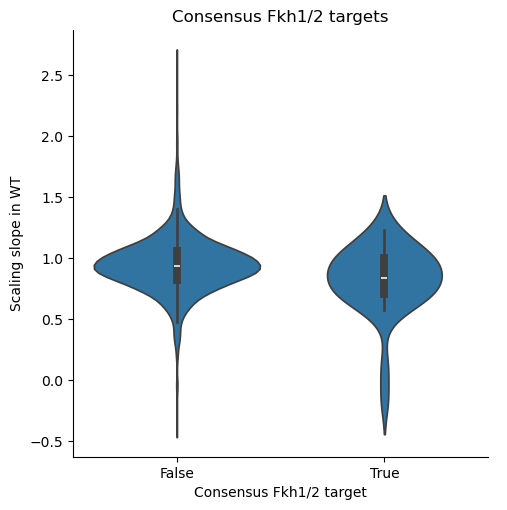

In [102]:
sb.catplot(delta_slopes,y='WT',x='Consensus Fkh1/2 target',kind='violin')
plt.ylabel('Scaling slope in WT')
plt.title('Consensus Fkh1/2 targets')

fkh12_result = stats.ttest_ind(delta_slopes['WT'].dropna(),delta_slopes[delta_slopes['Consensus Fkh1/2 target']]['WT'].dropna())
print(f'Fkh1/2 v. WT, scaling slope in WT: T-test P = {fkh12_result[1]}')
plt.savefig(path.join(dirname,'fkh_targets_wtslope.eps'),format='eps')

Fkh1/2 v. WT, scaling slope in fkh1: T-test P = 0.0004037549777888394


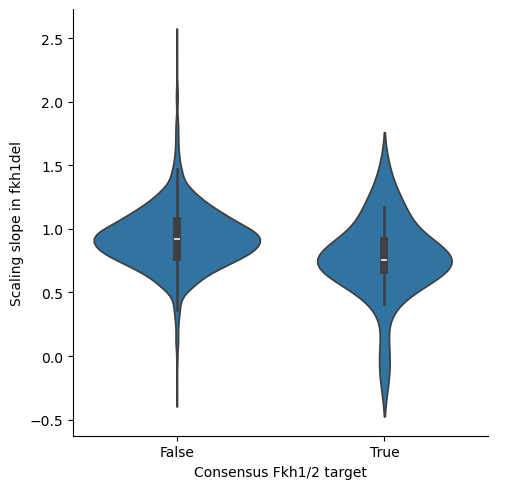

In [103]:

sb.catplot(delta_slopes,y='fkh1',x='Consensus Fkh1/2 target',kind='violin')
fkh12_result = stats.ttest_ind(delta_slopes['fkh1'].dropna(),delta_slopes[delta_slopes['Consensus Fkh1/2 target']]['fkh1'].dropna())
plt.ylabel('Scaling slope in fkh1del')
print(f'Fkh1/2 v. WT, scaling slope in fkh1: T-test P = {fkh12_result[1]}')
plt.savefig(path.join(dirname,'fkh_targets_fkh1slope.eps'),format='eps')

Fkh1/2 v. WT, scaling slope in fkh1: T-test P = 0.001959241158360326


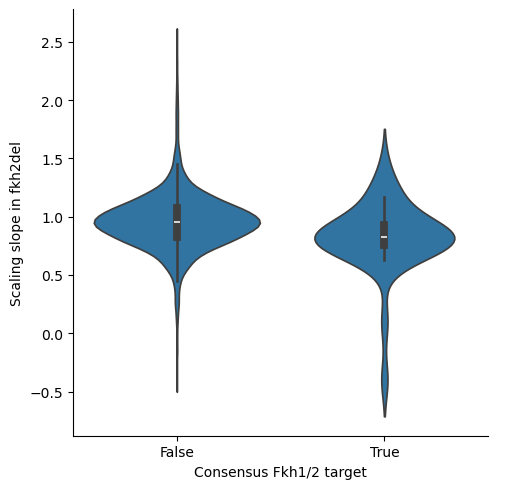

In [104]:

sb.catplot(delta_slopes,y='fkh2',x='Consensus Fkh1/2 target',kind='violin')
fkh12_result = stats.ttest_ind(delta_slopes['fkh2'].dropna(),delta_slopes[delta_slopes['Consensus Fkh1/2 target']]['fkh2'].dropna())
plt.ylabel('Scaling slope in fkh2del')
print(f'Fkh1/2 v. WT, scaling slope in fkh1: T-test P = {fkh12_result[1]}')
plt.savefig(path.join(dirname,'fkh_targets_fkh2slope.eps'),format='eps')


In [105]:
len(delta_slopes)

2530

NameError: name 'plot_slopegraph' is not defined

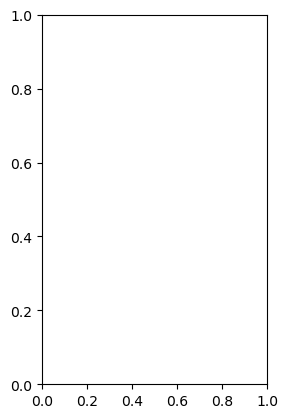

In [159]:
'''
Figure 6D: plot everything together on the same boxplot as a paired slopeograph
'''
fkh12_targets = delta_slopes[delta_slopes['Consensus Fkh1/2 target']]

from scipy import stats

# Fkh1 delete
ax1 = plt.subplot(1,2,1)
plot_slopegraph(fkh12_targets['WT'],fkh12_targets['fkh1'])
plt.plot( [1,2],[fkh12_targets['WT'].mean(),fkh12_targets['fkh1'].mean()],color='r')
plt.xticks([1,2],labels=['WT','fkh1del'])
plt.ylabel('Scaling slope')

results = stats.ttest_rel(fkh12_targets['WT'],fkh12_targets['fkh1'])
print(f'Paired T-test: P = {results.pvalue}')
plt.title(f'P = {results.pvalue:.2f}')

# Fkh1 delete
plt.subplot(1,2,2,sharey=ax1)
plot_slopegraph(fkh12_targets['WT'],fkh12_targets['fkh2'])
plt.plot( [1,2],[fkh12_targets['WT'].mean(),fkh12_targets['fkh2'].mean()],color='r')
plt.xticks([1,2],labels=['WT','fkh2del'])
plt.ylabel('Scaling slope')

results = stats.ttest_rel(fkh12_targets['WT'],fkh12_targets['fkh2'])
print(f'Paired T-test: P = {results.pvalue}')
plt.title(f'P = {results.pvalue:.2f}')

plt.savefig(path.join(dirname,'fkh_targets_wt_v_mutants.eps'),format='eps')

Paired T-test: P = 0.13812421804872155


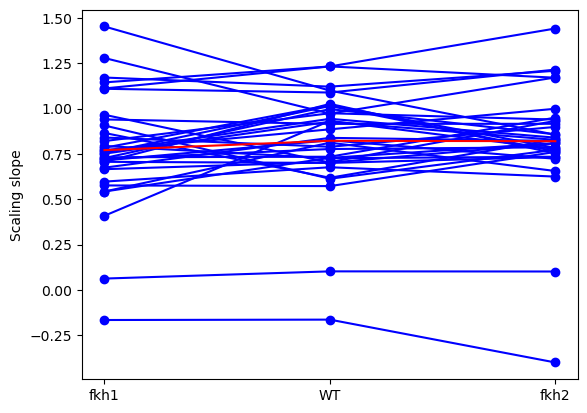

In [160]:
'''
Figure 6D: plot everything together on the same boxplot as a paired slopeograph
'''
fkh12_targets = delta_slopes[delta_slopes['Consensus Fkh1/2 target']]

# Fkh1 delete

def plot_threeway_line(x,y,z):
    assert(x.shape == y.shape)
    assert(y.shape == z.shape)
    plt.plot(x,y)

plt.plot(fkh12_targets[['fkh1','WT','fkh2']].T,color='b',marker='o')
plt.plot(fkh12_targets[['fkh1','WT','fkh2']].mean(),color='r')
plt.ylabel('Scaling slope')

results = stats.ttest_rel(fkh12_targets['WT'],fkh12_targets['fkh1'])
print(f'Paired T-test: P = {results.pvalue}')
# plt.title(f'P = {results.pvalue:.2f}')

plt.savefig(path.join(dirname,'fkh_targets_wt_v_mutants.svg'),format='svg')

Paired T-test: P = 0.13812421804872155


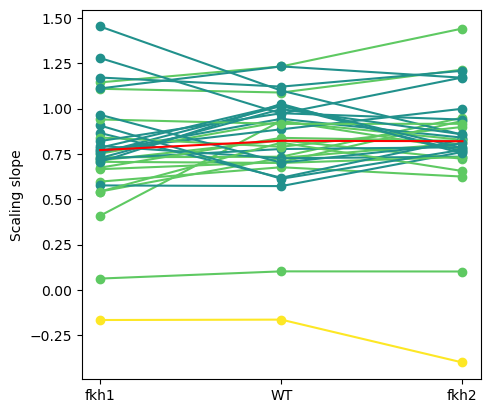

In [161]:
# Load n-mer count
fkh12_targets = delta_slopes[delta_slopes['Consensus Fkh1/2 target']]
nmer_counts = pd.read_csv(path.join(dirname,'truncated_6mer_joined.csv'),index_col=0)
viridis = pl.cm.viridis(np.linspace(0,1,5))

'''
Figure 6D: plot everything together on the same boxplot as a paired slopeograph
'''

def plot_threeway_line(x,y,z):
    assert(x.shape == y.shape)
    assert(y.shape == z.shape)
    plt.plot(x,y)

fkh12_targets = fkh12_targets.merge(nmer_counts['# concats'],left_index=True,right_index=True)

for i,row in fkh12_targets.iterrows():
    plt.plot(row[['fkh1','WT','fkh2']].T,
             color=viridis[row['# concats']],marker='o')
plt.plot(fkh12_targets[['fkh1','WT','fkh2']].mean(),color='r')
plt.ylabel('Scaling slope')

results = stats.ttest_rel(fkh12_targets['WT'],fkh12_targets['fkh1'])
print(f'Paired T-test: P = {results.pvalue}')
# plt.title(f'P = {results.pvalue:.2f}')

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.savefig(path.join(dirname,'fkh_targets_wt_v_mutants.svg'),format='svg')

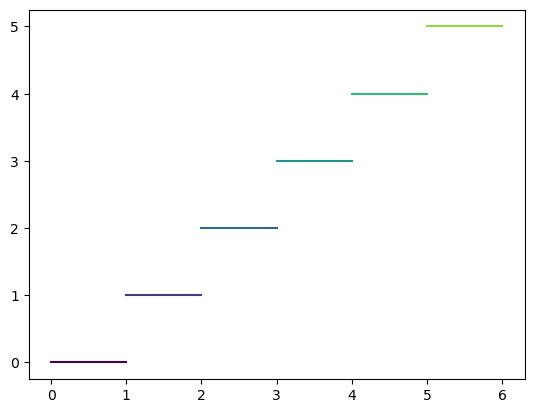

In [150]:
for i in range(6):
    plt.plot([i,i+1],[i,i],color=viridis[i])

In [152]:
fkh12_targets.sort_values('# concats')

,Name,WT,fkh1,fkh2,fkh1_del,fkh2_del,fkh1_deviation_from_wt,fkh1_covary_with_wt,fkh2_deviation_from_wt,fkh2_covary_with_wt,Any Fkh1/2 target,Consensus Fkh1/2 target,# concats
YLR335W,NUP2,0.777001,0.722849,0.786584,-0.054152,0.009583,-0.038291,1.060554,0.006776,1.105621,False,True,2
YMR197C,VTI1,1.019055,0.783903,0.783173,-0.235152,-0.235882,-0.166277,1.274884,-0.166794,1.274368,True,True,2
YPR033C,HTS1,1.121227,1.171505,1.208814,0.050278,0.087587,0.035552,1.621207,0.061933,1.647588,False,True,2
YCL064C,CHA1,0.612940,0.906887,0.772955,0.293947,0.160014,0.207852,1.074680,0.113147,0.979976,False,True,2
YBR037C,SCO1,1.232798,1.111210,1.170426,-0.121588,-0.062371,-0.085975,1.657464,-0.044103,1.699336,True,True,2
YML063W,RPS1B,1.026011,0.705849,0.752355,-0.320162,-0.273656,-0.226388,1.224610,-0.193504,1.257495,False,True,2
YFR004W,RPN11,0.972319,1.279180,1.171964,0.306861,0.199645,0.216983,1.592050,0.141170,1.516237,True,True,2
YHR200W,RPN10,0.974387,0.820856,0.939508,-0.153531,-0.034879,-0.108563,1.269428,-0.024663,1.353328,False,True,2
YLR209C,PNP1,0.885674,0.771193,0.999156,-0.114481,0.113482,-0.080950,1.171582,0.080244,1.332777,True,True,2
YMR076C,PDS5,1.014287,0.755135,0.764334,-0.259152,-0.249953,-0.183248,1.251170,-0.176743,1.257675,False,True,2
